# Описание датасета

Датасет собран с помощью тех пользователей, что делились прослушиваемыми песнями в запрещённом twitter через ушедший из РФ spotify и представляет из себя таблицу с четыремя столбцами:
1. ID пользователя
2. Имя исполнителя
3. Название песни
4. Название плейлиста, из которого проигрывалась песня

Мы будем строить рекомендательную систему для поиска исполнителей и, как следствие, использовать будем только два первых столбца.

Сам датасет доступен на kaggle: https://www.kaggle.com/datasets/andrewmvd/spotify-playlists

# Идея построения рекомендательной системы

Для начала мы строим граф вершины которого - слушатели. В каждой вершине будет содержаться множество исполнителей, которых слушал пользователь. Пусть для некоторых двух слушателей A и B - множество исполнителей, которых слушал первый и второй пользователи соот-но, тогда эти вершины соединяются ребром, если $$\frac{|A \cap B|}{min(|A|, |B|)} > \epsilon$$

Далее делаем то же самое, но в качестве вершин будут выступать исполнители.

Параметр эпсилон для обоих случаев определим позже.

Далее с помощью алгоритма node2vec (описанного в [этой работе](https://arxiv.org/abs/1607.00653)) представляем каждую вершину каждого графа вектором фиксированной длины. После этого мы имеем три варианта рекомендательной системы:
1. Для заданного слушателя находить ближайшего к нему пользователя и рекомендовать первому то, что слушает последний 
2. Для заданного исполнителя или списка исполнителей находить список наиболее похожих артистов и рекомендовать их
3. Просмотреть пересечение описанных выше рекомендаций и рекомендовать их

# Важно

Ниже используется [эта](https://github.com/eliorc/node2vec) реализация node2vec. К сожалению, она реализована на python'е, а значит, априори не эффективна в смысле времени выполнения. Другие, более эффективные, реализации этого алгоритма (например, [эта](https://github.com/aditya-grover/node2vec) и [эта](https://github.com/snap-stanford/snap/tree/master/examples/node2vec)) не имеют python-интерфейса.

В силу вышесказанного, придётся идти на некоторые ухищрения и даже, к сожалению, компромиссы, чтоб этот блокнот выполнялся за разумное время

# Ближе к делу

In [1]:
import numpy as np
import pandas as pd
import networkx as nx # библиотека для работы с графами
import random

from node2vec import Node2Vec
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm, trange # для отслеживания времени выполнения циклов

Данных очень много, а используемый здесь алгоритм, как упоминалось ранее, реализован на python'е, так что использовать мы будем лишь случайную половину датасета

In [2]:
random.seed(1) # Установка инициализатора генератора случайных чисел для обеспечения повторяемости 
p = 0.5

In [3]:
df = pd.read_csv(r'data\spotify_dataset.csv', on_bad_lines = 'skip', skiprows = lambda i: random.random() > p)
df.sample(10)

,user_id,"""artistname""","""trackname""","""playlistname"""
3764902,a269d6d18b4a2278e109c77984d5d69a,Caspar Babypants,Being for the Benefit of Mr. Kite,kurtcobain mix tape 1989
3056450,6e5cbfe3f56e26d6ea483c195c301664,El sueño de Morfeo,Nos vemos en el camino,Starred
2376113,322fb7511b717ac69b728e68d685aa0c,Rye Rye,New Thing,Starred
541298,48b43f9ece4370dbe10fe03ecb4649a2,Coldplay,Midnight,The Last Leg
5703813,36ed222dab541663004adc160317e69d,Styx,Mr. Roboto,Liked from Radio
2462454,f93f02fdd84dcbc5f4d134fd610d8359,Go Radio,Strength to Stay,Workout
5304744,ef91d5bcbb4ca460ab33e09dd490a724,The Go! Team,Feelgood By Numbers,Music From Oscar (2010)
197659,fe7d1673dddda71ea695f21974c09872,Fishbone,Swim,Last Action Hero (Soundtrack) – Last Action Hero
5898447,a892024a31930b40e70491f8e9f09143,Original Crescent City Jazzers,Christine,Various Artists – 1920's Jazz New Orleans - Gr...
3628636,9c6dc5b8e9c69c7b47cc53719b06d072,Nat Kendricks And The Swans,(Do The) Mashed Potatoes Part 1,R&B * Soul * Funk * Soul-Blues Album Collxn


Столбцы названы несколько странно. Поправим это

In [4]:
df.rename(columns = {' "artistname"': 'artistname', 
                     ' "trackname"': 'trackname', 
                     ' "playlistname"': 'playlistname'}, inplace = True)

Поскольку использовать мы собираемся только исполнителей, столбец с названием песни и плейлистом удаляем

In [5]:
df.drop(columns = ['trackname', 'playlistname'], inplace = True)

Вероятно, после удаления двух столбцов в таблице появились повторы.

In [6]:
df.duplicated().sum()

4298306

Удалим их

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.sample(10)

,user_id,artistname
3426381,2867816a8d25cebe589aec52870d0b9e,Luis Miguel
276784,c78bc4044517a6e203275cabf773a739,Joan Chamorro
242669,f707a22a705ac44e45be0cf8d8af2e4d,K'NAAN
2956484,0d88d21a59ed1a07aa1f90db706599c6,Gucci Mane
2819305,cd2892d86e57d8d2218a2a0715611ee8,Claudio Monteverdi
4068800,e9022ff9355cab700ee7c0ea7a80fe89,Kelis
3354788,10b213ce9c0ec1450a341dce361ca0b7,MN8
6160504,6d7ef5f20f9129fc5a9a36c484469e21,U.K.
4911502,5968fe6ff4531c2efd244584f35ea94a,Laura Mvula
2399933,37c3869d92ea70aea64988616c0c1fff,Made famous by Adele


In [13]:
print('Уникальных слушателей: {}'.format(df['user_id'].nunique()))
print('Уникальных исполнителей: {}'.format(df['artistname'].nunique()))

Уникальных слушателей: 15720
Уникальных исполнителей: 219913


С целью, опять же, облегчить вычисления, удалим непопулярных исполнителей (тех, которых прослушали меньше пятидясети пользователей), а так же слишком пассивных и слишком активных пользователей

In [14]:
df = df.groupby('artistname').filter(lambda x: len(x) >= 50)
df = df.groupby('user_id').filter(lambda x: 10 <= len(x) <= 1000)

In [15]:
print('Уникальных слушателей: {}'.format(df['user_id'].nunique()))
print('Уникальных исполнителей: {}'.format(df['artistname'].nunique()))

Уникальных слушателей: 12652
Уникальных исполнителей: 6560


Для удобства и экономии памяти поставим каждому исполнителю и слушателю в соответствие некоторое число 

In [16]:
user_id_le = LabelEncoder()
user_id_le.fit(df['user_id'])
df['user_id'] = user_id_le.transform(df['user_id'])

artist_le = LabelEncoder()
artist_le.fit(df['artistname'])
df['artistname'] = artist_le.transform(df['artistname'])

In [17]:
df

,user_id,artistname
1,7759,1774
2,7759,1773
4,7759,4359
7,7759,1252
14,7759,2912
16,7759,3358
31,7759,1248
35,7759,4166
36,7759,4378
37,7759,6064


Сформируем отображение вида "пользователь" - "множество исполнителей, которых он слушал". Используется frozenset вместо "обычного" set дабы исключить возможность случайно что-то изменить

In [14]:
user_artists = dict()
for user, sub_df in df.groupby('user_id'):
    user_artists[user] = frozenset(sub_df['artistname'])

Примечательно, что распределение кол-ва уникальных исполнителей, которых слушали пользователи похоже на экспоненциальное 

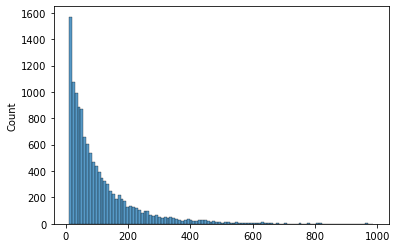

In [15]:
user_lens = [len(val) for val in user_artists.values()]
sns.histplot(user_lens);

# Первый вариант рекомендательной системы 

Определим множество пользователей, которые будут соединены в итоговом графе.

Стоит заметить, что тут (как и далее при формировании графа исполнителей) параметр EPS подбирался так, чтоб граф с одной стороны не был слишком большим, а с другой не был сильно разрежен (в смысле количества связных компонент)

In [20]:
EPS = 0.45
edges = []
keys = list(user_artists.keys())
for node1 in tqdm(keys):
    for node2 in keys[keys.index(node1) + 1:]:
        val1, val2 = user_artists[node1], user_artists[node2]
        if len(val1 & val2) / min(len(val1), len(val2)) > EPS:
            edges.append((node1, node2))

  0%|          | 0/12652 [00:00<?, ?it/s]

In [17]:
users_gr = nx.Graph()
users_gr.add_nodes_from(df['user_id'])
users_gr.add_edges_from(edges)
print(users_gr)
print(f'В среднем по {int(len(edges) / len(user_artists))} рёбер (ребра) на вершину')
print(f'В графе {nx.number_connected_components(users_gr)} связных (связная) компонент(а)')

Graph with 12652 nodes and 730271 edges
В среднем по 57 рёбер (ребра) на вершину
В графе 76 связных (связная) компонент(а)


Стоит заметить, что у нас получилась некоторая кластеризация пользователей, которая в теории может обладать некоторыми интересными свойствами

Возвращаясь к сказанному в самом начале, приходится идти на компромиссы и генерировать всего 75 "прогулок" по графу длины 30. Очевидно, этого слишком мало, чтоб использовать всю информацию, заложенную в графе, однако имеем что имеем

In [22]:
usr_n2v = Node2Vec(users_gr, dimensions = 64, walk_length = 30, num_walks = 75, p = 10, q = 5)

Generating walks (CPU: 1): 100%|██████████| 75/75 [35:06<00:00, 28.09s/it]


За несколько "шагов" по графу можно в теории прийти от пользователя, предпочитающего, например, классическую музыку к пользователю, предпочитающему тяжёлый рок, так что ширину окна берём умеренную

In [23]:
usr_model = usr_n2v.fit(window = 5, min_count = 1)

Ну и осталось написать функции, что дадут рекомендации, исходя из полученного векторого представления графа

In [90]:
def get_recomendations_by_user(user, usr_model = usr_model, user_artists = user_artists, artist_le = artist_le, out = 'ids'):
    '''
    Функция для выдачи рекомендация пользователю
    
    Параметры:
        user (int): ID пользователя, которомы мы хотим дать рекомендации
        usr_model: модель из модуля gensim, что содержит векторные представления пользователей
        user_artists (dict): отображение вида "пользователь" - "множество прослушанных им исполнителей"
        artist_le (sklearn.LabelEncoder): LabelEncoder для перевода чисел в исполнителей и наоборот
        out (str): функция возвращает ID рекомендованных исполнителей, если out == 'ids' и имена, если out == 'names'
    Возвращаемое значение:
        Список рекомендованных пользователю user исполнителей
    '''
    assert out in ['ids', 'names'], 'Некорретный параметр out'
    # находим ID ближайшего пользователя. 
    m_s = usr_model.wv.most_similar(str(user))[0][0]
    if out == 'ids':
        return list(user_artists[int(m_s)] - user_artists[user])
    else:
        return artist_le.inverse_transform(list(user_artists[int(m_s)] - user_artists[user])) 

Помимо всего прочего, в демонстрационных целях нам понадобится функция, что по данному пользователю выведет список имён прослушанных им исполнителей

In [91]:
def get_artists(user, user_artists = user_artists, out = 'ids'):
    '''
    Функция для выдачи рекомендация пользователю
    
    Параметры:
        user (int): ID пользователя, которомы мы хотим дать рекомендации
        user_artists (dict): отображение вида "пользователь" - "множество прослушанных им исполнителей"
        out (str): функция возвращает ID рекомендованных исполнителей, если out == 'ids' и имена, если out == 'names'
    Возвращаемое значение:
        Список прослушанных пользователем user исполнителей
    '''
    assert out in ['ids', 'names'], 'Некорретный параметр out'
    if out == 'ids':
        return list(user_artists[user])
    else:
        return artist_le.inverse_transform(list(user_artists[user]))

## Демонстрация работы алгоритма

In [25]:
get_artists(1, out = 'names')

array(['Ron Pope', 'Bastille', 'Andrew Belle', 'Ed Sheeran', 'Fuel',
       'Dead by April', 'Deaf Havana', 'Lana Del Rey', 'Brandi Carlile',
       'Damien Rice', 'Tom Odell', 'Black Veil Brides', 'Ben Howard',
       'Avenged Sevenfold', 'Evanescence', 'Seether', 'The xx', 'Broods',
       'Theory Of A Deadman', 'Creed', 'Bryan Adams', 'Adele', 'Saliva',
       'Daughter', 'Daughtry', "Plain White T's", 'The Neighbourhood'],
      dtype=object)

In [64]:
get_recomendations_by_user(1, out = 'names')[:20]

array(['Tim Hughes', 'Matt Redman', 'blink-182', 'Friendly Fires',
       'Studio 99', 'Linkin Park', 'OneRepublic', 'Nicki Minaj',
       'Twin Atlantic', 'Boys Like Girls', 'Muse', 'A Day To Remember',
       'Sum 41', 'Kings Of Leon', 'McFly', 'The Red Jumpsuit Apparatus',
       'My Chemical Romance', 'Scouting For Girls', 'The Kooks',
       'Hillsong United'], dtype=object)

In [65]:
get_artists(10, out = 'names')

array(['Kid Cudi', 'Jason Mraz', 'Asher Roth', 'The Postal Service',
       'The Clash', 'Prince', 'Justin Timberlake', 'Gym Class Heroes',
       '50 Cent', 'Beck', 'Disturbed', 'Coldplay', 'Daft Punk',
       'Gnarls Barkley', 'Tyler, The Creator', 'Black Star',
       'Lupe Fiasco', 'The Weeknd', 'Kanye West', 'Nirvana', 'N.E.R.D.',
       'Danger Mouse', 'Ryan Leslie', 'Gorillaz', 'The Shins',
       'Broken Bells', 'Blur', 'Bob Marley', 'Pink Floyd', 'Frank Ocean',
       'The Strokes', 'Robin Thicke', 'Travis Barker', 'Cee Lo Green',
       'Julian Casablancas'], dtype=object)

In [66]:
get_recomendations_by_user(10, out = 'names')[:20]

array(['Jason Derulo', 'Gil Scott-Heron & Jamie xx', "D'Angelo", 'Eagles',
       '2 Chainz', 'DMX', 'Ludacris', 'Muse', 'Black Lips', 'Rudimental',
       'Death From Above 1979', 'The Cribs', 'Xzibit', 'Alex Turner',
       'Hozier', 'JAY Z', 'The Rolling Stones', 'Yeah Yeah Yeahs',
       'The White Stripes', 'The Libertines'], dtype=object)

# Второй вариант рекомендательной системы 

Аналогично предыдущему случаю, формируем отображение вида "исполнитель" - "множество его слушателей" 

In [34]:
artist_user = dict()
for artist, sub_df in df.groupby(by = 'artistname'):
    artist_user[artist] = frozenset(sub_df['user_id'])

Определим, каких исполнителей должно соединить ребром

In [35]:
EPS = 0.4
art_edges = []
keys = list(artist_user.keys())
for node1 in tqdm(keys):
    for node2 in keys[keys.index(node1) + 1:]:
        val1, val2 = artist_user[node1], artist_user[node2]
        if len(val1 & val2) / min(len(val1), len(val2)) > EPS:
            art_edges.append((node1, node2))

  0%|          | 0/6560 [00:00<?, ?it/s]

In [36]:
artists_gr = nx.Graph()
artists_gr.add_nodes_from(df['artistname'])
artists_gr.add_edges_from(art_edges)
print(artists_gr)
print(f'В среднем по {int(len(art_edges) / len(artist_user))} рёбер (ребра) на вершину')
print(f'В графе {nx.number_connected_components(artists_gr)} связных компонент')

Graph with 6560 nodes and 114148 edges
В среднем по 17 рёбер (ребра) на вершину
В графе 12 связных компонент


Занятно, что распределение снова походит на экспоненциальное 

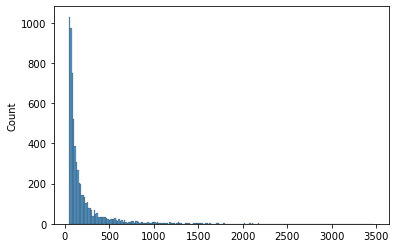

In [37]:
art_lens = [len(val) for val in artist_user.values()]
sns.histplot(art_lens);

В этом случае и длина "прогулки" и их количество больше, чем в случае с пользователями, а сам граф заметно меньше, так что в этом случае модель должна уловить заметно больше свойств графа

In [39]:
artist_n2v = Node2Vec(artists_gr, dimensions = 64, walk_length = 50, num_walks = 150, p = 10, q = 5)

Generating walks (CPU: 1): 100%|██████████| 150/150 [1:12:34<00:00, 29.03s/it]


In [40]:
art_model = artist_n2v.fit(window = 7, min_count = 1)

In [94]:
def get_recomendation_by_artist_id(artist_ids, art_model = art_model,
                                   artist_le = artist_le, topn = 15, out = 'ids'):
    '''
    Функция для рекомендации артистов на основе списка ID других артистов
    Параметры:
       artist_ids: ID исполнителя
       art_model: Модель, содержащая векторные представления артистов
       artist_le (sklearn.LabelEncoder): LabelEncoder для перевода чисел в исполнителей и наоборот
       topn (int): Количество исполнителей на выходе
       out (str): функция возвращает ID рекомендованных исполнителей, если out == 'ids' и имена, если out == 'names'
    Возвращаемое значение:
       topn рекомендованных исполнителей
    '''
    assert out in ['ids', 'names'], 'Некорретный параметр out'
    # в виду особенностей реализации, модель art_model ожидает на вход строки,
    # так что необходимо преобразовать числа в строки
    artist_ids = [str(_id) for _id in artist_ids]
    # находим topn ближайших векторов
    m_s = art_model.wv.most_similar(artist_ids, topn = topn)
    # функция выше возвращает список кортежей вида (ID исполнителя, косинус угла между этим исполнителем
    # и остальными), так что нас интересуют только первые элементы этих кортежей
    recs = [int(a[0]) for a in m_s]
    
    if out == 'ids':
        return recs
    else:
        return artist_le.inverse_transform(recs)

Для удобства и наглядной демонстрации работы этой системы, определим функцию, аналогичную той, что находится ячейкой выше, за тем лишь исключением, что принимать она будет не ID исполнителей, а их имена 

In [93]:
def get_recomendation_by_artist_names(artist_names, art_model = art_model, 
                                      artist_le = artist_le, topn = 15, out = 'ids'):
    '''
    Функция для рекомендации артистов на основе списка имён других артистов
    Параметры:
       artist_names (list): Список имён исполнителей, исходя из которых будут получены рекомендации 
       art_model: Модель, содержащая векторные представления артистов
       artist_le (sklearn.LabelEncoder): LabelEncoder для перевода чисел в исполнителей и наоборот
       topn (int): Количество исполнителей на выходе
       out (str): функция возвращает ID рекомендованных исполнителей, если out == 'ids' и имена, если out == 'names'
    Возвращаемое значение:
       topn рекомендованных исполнителей
    '''
    artist_ids = artist_le.transform(artist_names)
    return get_recomendation_by_artist_id(artist_ids, art_model, artist_le, topn = topn, out = out)

## Демонстрация работы алгоритма

In [75]:
get_recomendation_by_artist_names(['Eminem'], out = 'names')

array(['Snoop Dogg', 'Flo Rida', 'Rihanna', 'Vinnie Paz', 'Katy Perry',
       'Porta', 'Chris Brown', 'Dead by April', 'Pitbull', 'Nickelback',
       'Hollywood Undead', 'Nomy', 'David Guetta', 'JAY Z', 'Lil Wayne'],
      dtype=object)

In [87]:
get_recomendation_by_artist_names(['Eminem', 'Rihanna'], out = 'names')

array(['Katy Perry', 'David Guetta', 'Maroon 5', 'Beyoncé', 'Pitbull',
       'Avicii', 'Calvin Harris', 'Flo Rida', 'Porta', 'Dead by April',
       'Lady Gaga', 'Hollywood Undead', 'Bruno Mars', 'Usher',
       'Snoop Dogg'], dtype=object)

In [88]:
get_recomendation_by_artist_names(['2Pac'], out = 'names')

array(['Dr. Dre', 'The Notorious B.I.G.', 'Nas', 'Ice Cube',
       'Busta Rhymes', 'OutKast', 'Wu-Tang Clan', 'Ludacris', '50 Cent',
       'LL Cool J', 'Snoop Dogg', 'DMX', 'Lupe Fiasco',
       'A Tribe Called Quest', 'T.I.'], dtype=object)

In [89]:
get_recomendation_by_artist_names(['Jay-Z'], out = 'names')

array(['N.E.R.D.', 'Kris Kross', 'Sir Mix-A-Lot', "Quad City DJ's",
       'DJ Jazzy Jeff & The Fresh Prince', 'Montell Jordan', 'Diddy',
       'Wyclef Jean', 'Warren G', 'Estelle', 'Too $hort', 'Salt-N-Pepa',
       'DJ Kool', 'Bone Thugs-N-Harmony', 'Panjabi MC'], dtype=object)

# Третий вариант рекомендательной системы 

Потерпел фиаско. Напоминаю: предполагалось в качестве рекомендаций брать пересечение выходов первого и второго вариантов рекомендательной системы. Однако имеем следующее:

In [80]:
founded = False
for user_id in tqdm(user_artists.keys()):
    # список рекомендаций с использованием первого метода
    user_recs = get_recomendations_by_user(user_id, out = 'names')
    # список исполнителей, которых слушает данный пользователь 
    user_listen_to = get_artists(user_id, out = 'names')
    # список рекомендаций с использованием второго метода
    artist_recs = get_recomendation_by_artist_names(user_listen_to, topn = 30)
    # пересечение полученных выше рекомендаций 
    main_recs = list(set(user_recs) & set(artist_recs))
    
    if main_recs != []:
        founded = True
if not founded:
    print('Подходящих пользователей не нашлось')

  0%|          | 0/12652 [00:00<?, ?it/s]

Подходящих пользователей не нашлось


Связано ли это с принципиальным различием двух подходов или с недообученностью обоих не совсем ясно, но на случай, если кто-то захочет поэкспериментировать, прилагаю функцию, что реализует третий метод:

In [92]:
def get_recomendation(user_id, art_model = art_model, usr_model = usr_model, 
                      user_artist = user_artists, artist_le = artist_le, topn = 15):
    '''
    Функция, что получает рекомендации первыми двумя способами и возвращает их пересечение 
    Параметры:
        user_id (int): ID пользователя
        art_model: модель из модуля gensim, что содержит векторные представления артистов
        usr_model: модель из модуля gensim, что содержит векторные представления пользователей
        user_artists (dict): отображение вида "пользователь" - "множество прослушанных им исполнителей"
        artist_le (sklearn.LabelEncoder): LabelEncoder для перевода чисел в исполнителей и наоборот
        topn (int): Количество исполнителей на выходе
    '''
    # список рекомендаций с использованием первого метода
    user_recs = get_recomendations_by_user(user_id, usr_model = usr_model, user_artists = user_artists, 
                                           artist_le = artist_le, out = 'names')
    # список исполнителей, которых слушает данный пользователь 
    user_listen_to = get_artists(user_id, out = 'names')
    # список рекомендаций с использованием второго метода
    artist_recs = get_recomendation_by_artist_names(user_listen_to, art_model = art_model, 
                                                    artist_le = artist_le, topn = topn)
    
    return list(set(user_recs) & set(artist_recs))